<a href="https://colab.research.google.com/github/Vicky-0222/ML/blob/master/lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Задача классификации**



## 1. Загрузка библиотек и предобработка данных

In [ ]:
!pip install pandas scikit-learn seaborn scipy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Загрузка набора данных
df = pd.read_csv('/content/seeds.csv')
df

,area,perimeter,compactness,length,width,asymmetry,length.1
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175
...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044


In [ ]:
# проверка на пропущенные значения
print(df.isnull().sum())

area           0
perimeter      0
compactness    3
length         0
width          1
asymmetry      0
length.1       0
dtype: int64


In [ ]:
# Заполнение пропусков медианой
df_median = df.copy()
df_median.compactness = df_median.compactness.fillna(df_median.compactness.median())
df_median.width = df_median.width.fillna(df_median.width.median())

print(df_median.isnull().sum())


# Заполнение пропусков медианой
area           0
perimeter      0
compactness    0
length         0
width          0
asymmetry      0
length.1       0
dtype: int64


In [ ]:
df_median['perfect_seed'] = np.where(df_median['asymmetry'] <= 4, 1, 0) # чем ассимметрия меньше, тем идеальнее семечка
df_median.perfect_seed = df_median.perfect_seed.astype('category')

y = df_median['perfect_seed'] # целевая переменная
X = df_median.drop('perfect_seed', axis=1) # переменные для проверки влияния

X = X.drop('asymmetry', axis=1)
df_median.drop('asymmetry', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   area          210 non-null    float64 
 1   perimeter     210 non-null    float64 
 2   compactness   210 non-null    float64 
 3   length        210 non-null    float64 
 4   width         210 non-null    float64 
 5   length.1      210 non-null    float64 
 6   perfect_seed  210 non-null    category
dtypes: category(1), float64(6)
memory usage: 10.3 KB


In [ ]:
# Создаем копию данных
category_columns: list[str] = X.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X = pd.get_dummies(X, columns=category_columns,drop_first=True) # drop_first=True для избежания мультиколлинеарности


## 1.2 Проверка баланса
#### Проверка, насколько сбалансированы классы в нашей целевой переменной


In [ ]:
y.value_counts()

,count
perfect_seed,
1,121
0,89


## 1.3 Создание искусственного дисбаланса классов
#### Новая целевая переменная y_disbalanced, где 90% классов будут 1, а 10% - 0.



In [ ]:
from sklearn.utils import resample

# Объединеняем X и y
data = pd.concat([X, y], axis = 1)

# Разделяем на классы
majority = data[data['perfect_seed'] == 1]
minority = data[data['perfect_seed'] == 0]

# Уменьшаем количество экземпляров класса 0
minority_downsampled = resample(minority,
                              replace=False,
                              n_samples=int(len(majority)*0.1),
                               random_state=42)

# Объединяем обратно
data_disbalanced = pd.concat([majority, minority_downsampled])

# Новые X и y
X_disbalanced = data_disbalanced.drop('perfect_seed', axis=1)
y_disbalanced = data_disbalanced['perfect_seed']

# Проверяем новый баланс классов
print(y_disbalanced.value_counts())

perfect_seed
1    121
0     12
Name: count, dtype: int64


## 1.4 Обучаем логистическую регрессию на дисбалансе

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_disbalanced, y_disbalanced, test_size=0.3, random_state=42)

# Обучаем модель
model = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.90      1.00      0.95        36

    accuracy                           0.90        40
   macro avg       0.45      0.50      0.47        40
weighted avg       0.81      0.90      0.85        40



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
unique, counts = np.unique(y_pred, return_counts=True) #получаем уникальные значения и их количество в предсказанных данных

dict(zip(unique, counts))

{1: 40}

## 1.5 Создадим сбалансированную выборку и попробуем сделать тоже самое

In [ ]:
# Уменьшаем количество экземпляров класса 1
majority_downsampled = resample(majority,
                                replace=False,
                                n_samples=len(minority),
                                random_state=42)

# Объединяем обратно
data_balanced = pd.concat([majority_downsampled, minority])

# Новые X и y
X_balanced = data_balanced.drop('perfect_seed', axis=1)
y_balanced = data_balanced['perfect_seed']

print(y_balanced.value_counts())

perfect_seed
0    89
1    89
Name: count, dtype: int64


In [ ]:
# Разделяем данные на обучающую и тестовую выборки
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)

In [ ]:
print("Accuracy:", accuracy_score(y_test_bal, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_test_bal, y_pred_bal))

Accuracy: 0.6481481481481481

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.56      0.61        27
           1       0.62      0.74      0.68        27

    accuracy                           0.65        54
   macro avg       0.65      0.65      0.65        54
weighted avg       0.65      0.65      0.65        54



In [ ]:
unique, counts = np.unique(y_pred_bal, return_counts=True) # получаем уникальные значения и их количество в предсказанных данных

dict(zip(unique, counts))

{0: 22, 1: 32}

In [ ]:
# Выбираем числовые признаки
numeric_features = X_balanced.select_dtypes(include=['float64']).columns.tolist()

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
X_balanced[numeric_features] = scaler.fit_transform(X_balanced[numeric_features])

In [ ]:
# Разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)

In [ ]:
print("Accuracy:", accuracy_score(y_test_bal, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_test_bal, y_pred_bal))

Accuracy: 0.6296296296296297

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.48      0.57        27
           1       0.60      0.78      0.68        27

    accuracy                           0.63        54
   macro avg       0.64      0.63      0.62        54
weighted avg       0.64      0.63      0.62        54



In [ ]:
unique, counts = np.unique(y_pred_bal, return_counts=True) # получаем уникальные значения и их количество в предсказанных данных

dict(zip(unique, counts))

{0: 19, 1: 35}

## 2. Метрики качества классификации

In [ ]:
# Разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# Вычисляем матрицу ошибок (TP, FP, TN, FN)
conf_matrix = confusion_matrix(y_test_bal, y_pred_bal)
tn, fp, fn, tp = conf_matrix.ravel()

# Рассчитываем метрики
accuracy = accuracy_score(y_test_bal, y_pred_bal)
precision = precision_score(y_test_bal, y_pred_bal)
recall = recall_score(y_test_bal, y_pred_bal)
f1 = f1_score(y_test_bal, y_pred_bal)
roc_auc = roc_auc_score(y_test_bal, y_pred_bal)

# Генерируем classification_report
class_report = classification_report(y_test_bal, y_pred_bal, output_dict=True)

# Формируем результаты для наглядного вывода
results = {
    "True Negatives (TN)": tn,
    "False Positives (FP)": fp,
    "False Negatives (FN)": fn,
    "True Positives (TP)": tp,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "ROC-AUC": roc_auc,
}

# Округляем все значения в словаре до двух знаков после запятой и возвращаем в виде dict.items()
rounded_items = {k: round(v, 2) for k, v in results.items()}

In [ ]:
print(classification_report(y_test_bal, y_pred_bal))

              precision    recall  f1-score   support

           0       0.68      0.48      0.57        27
           1       0.60      0.78      0.68        27

    accuracy                           0.63        54
   macro avg       0.64      0.63      0.62        54
weighted avg       0.64      0.63      0.62        54



In [ ]:
conf_matrix # Матрица
# TN FP
# FN TP

array([[13, 14],
       [ 6, 21]])

In [ ]:
rounded_items

{'True Negatives (TN)': 13,
 'False Positives (FP)': 14,
 'False Negatives (FN)': 6,
 'True Positives (TP)': 21,
 'Accuracy': 0.63,
 'Precision': 0.6,
 'Recall': 0.78,
 'F1-score': 0.68,
 'ROC-AUC': 0.63}

#### Правильно предсказанные отрицательные примеры - 13. Верно определили 13 примеров как класс 1 не является классом 0 или наоборот.
#### Ошибочно предсказанные положительные примеры - предсказали 14 примеров как класс 1 является классом 0 или наоборот
#### Ошибочно предсказанные отрицательные примеры - не определили 6 примеров как класс 1 является классом 1
#### правильно предсказанные положительные примеры - 21. Верно определили, что класс 1 является классом 1 или класс 0  является классом 0


#### Общая точность равна 0.63, это значит что 63% всех предсказаний модели были верными.
#### 60% верных положительных предсказаний среди всех предсказанных положительных.  
#### 78% верных положительных предсказаний среди всех фактически положительных случаев.
#### Гармонически среднее между precision и recall равна 68%.
#### ROC-AUC равна 0.63 из этого можно понять что производительность модели стабильна. Модель в принципе способна различать классы.

## 3. Задача мультиклассовой классификации

#### В качестве y - используем asymmetry

In [ ]:
y = df_median['asymmetry'].astype('int64')

X = df_median.drop(['asymmetry', 'perfect_seed'], axis=1)

In [ ]:
# Создаем копию данных
category_columns: list[str] = X.select_dtypes(include=['category']).columns

# Применяем One-Hot Encoding
X = pd.get_dummies(X, columns=category_columns,drop_first=True)

In [ ]:
X

,area,perimeter,compactness,length,width,length.1
0,15.26,14.84,0.8710,5.763,3.312,5.220
1,14.88,14.57,0.8811,5.554,3.333,4.956
2,14.29,14.09,0.9050,5.291,3.337,4.825
3,13.84,13.94,0.8955,5.324,3.379,4.805
4,16.14,14.99,0.9034,5.658,3.562,5.175
...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,4.870
206,11.23,12.88,0.8511,5.140,2.795,5.003
207,13.20,13.66,0.8883,5.236,3.232,5.056
208,11.84,13.21,0.8521,5.175,2.836,5.044


## 3.1 Алгоритм дерева принятия решений

In [ ]:
from sklearn.tree import DecisionTreeClassifier
# Разделяем данные
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучаем модель
tree_model = DecisionTreeClassifier(random_state=42, max_depth=10)
tree_model.fit(X_train_multi, y_train_multi)

# Предсказания
y_pred_multi = tree_model.predict(X_test_multi)

In [ ]:
from sklearn.metrics import classification_report

print("\nClassification Report:\n", classification_report(y_test_multi, y_pred_multi))


Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.14      0.11      0.12         9
           2       0.27      0.50      0.35        12
           3       0.41      0.54      0.47        13
           4       0.62      0.53      0.57        15
           5       0.50      0.10      0.17        10
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         1

    accuracy                           0.37        63
   macro avg       0.22      0.20      0.19        63
weighted avg       0.38      0.37      0.34        63



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

In [ ]:
accuracy_score(y_test_multi, y_pred_multi)

0.36507936507936506

In [ ]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test_multi, y_pred_multi)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


0.22286324786324785

### Важность признаков
#### Признаки, которые внесли наибольший вклад в модель

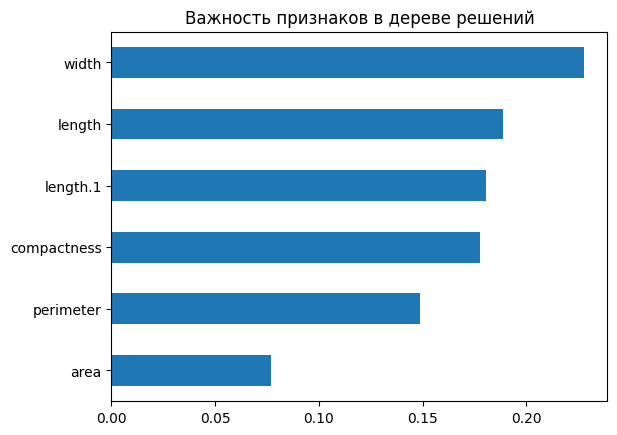

In [ ]:
import matplotlib.pyplot as plt

feature_importances = pd.Series(tree_model.feature_importances_, index=X.columns)
feature_importances.sort_values().plot(kind='barh')
plt.title('Важность признаков в дереве решений')
plt.show()

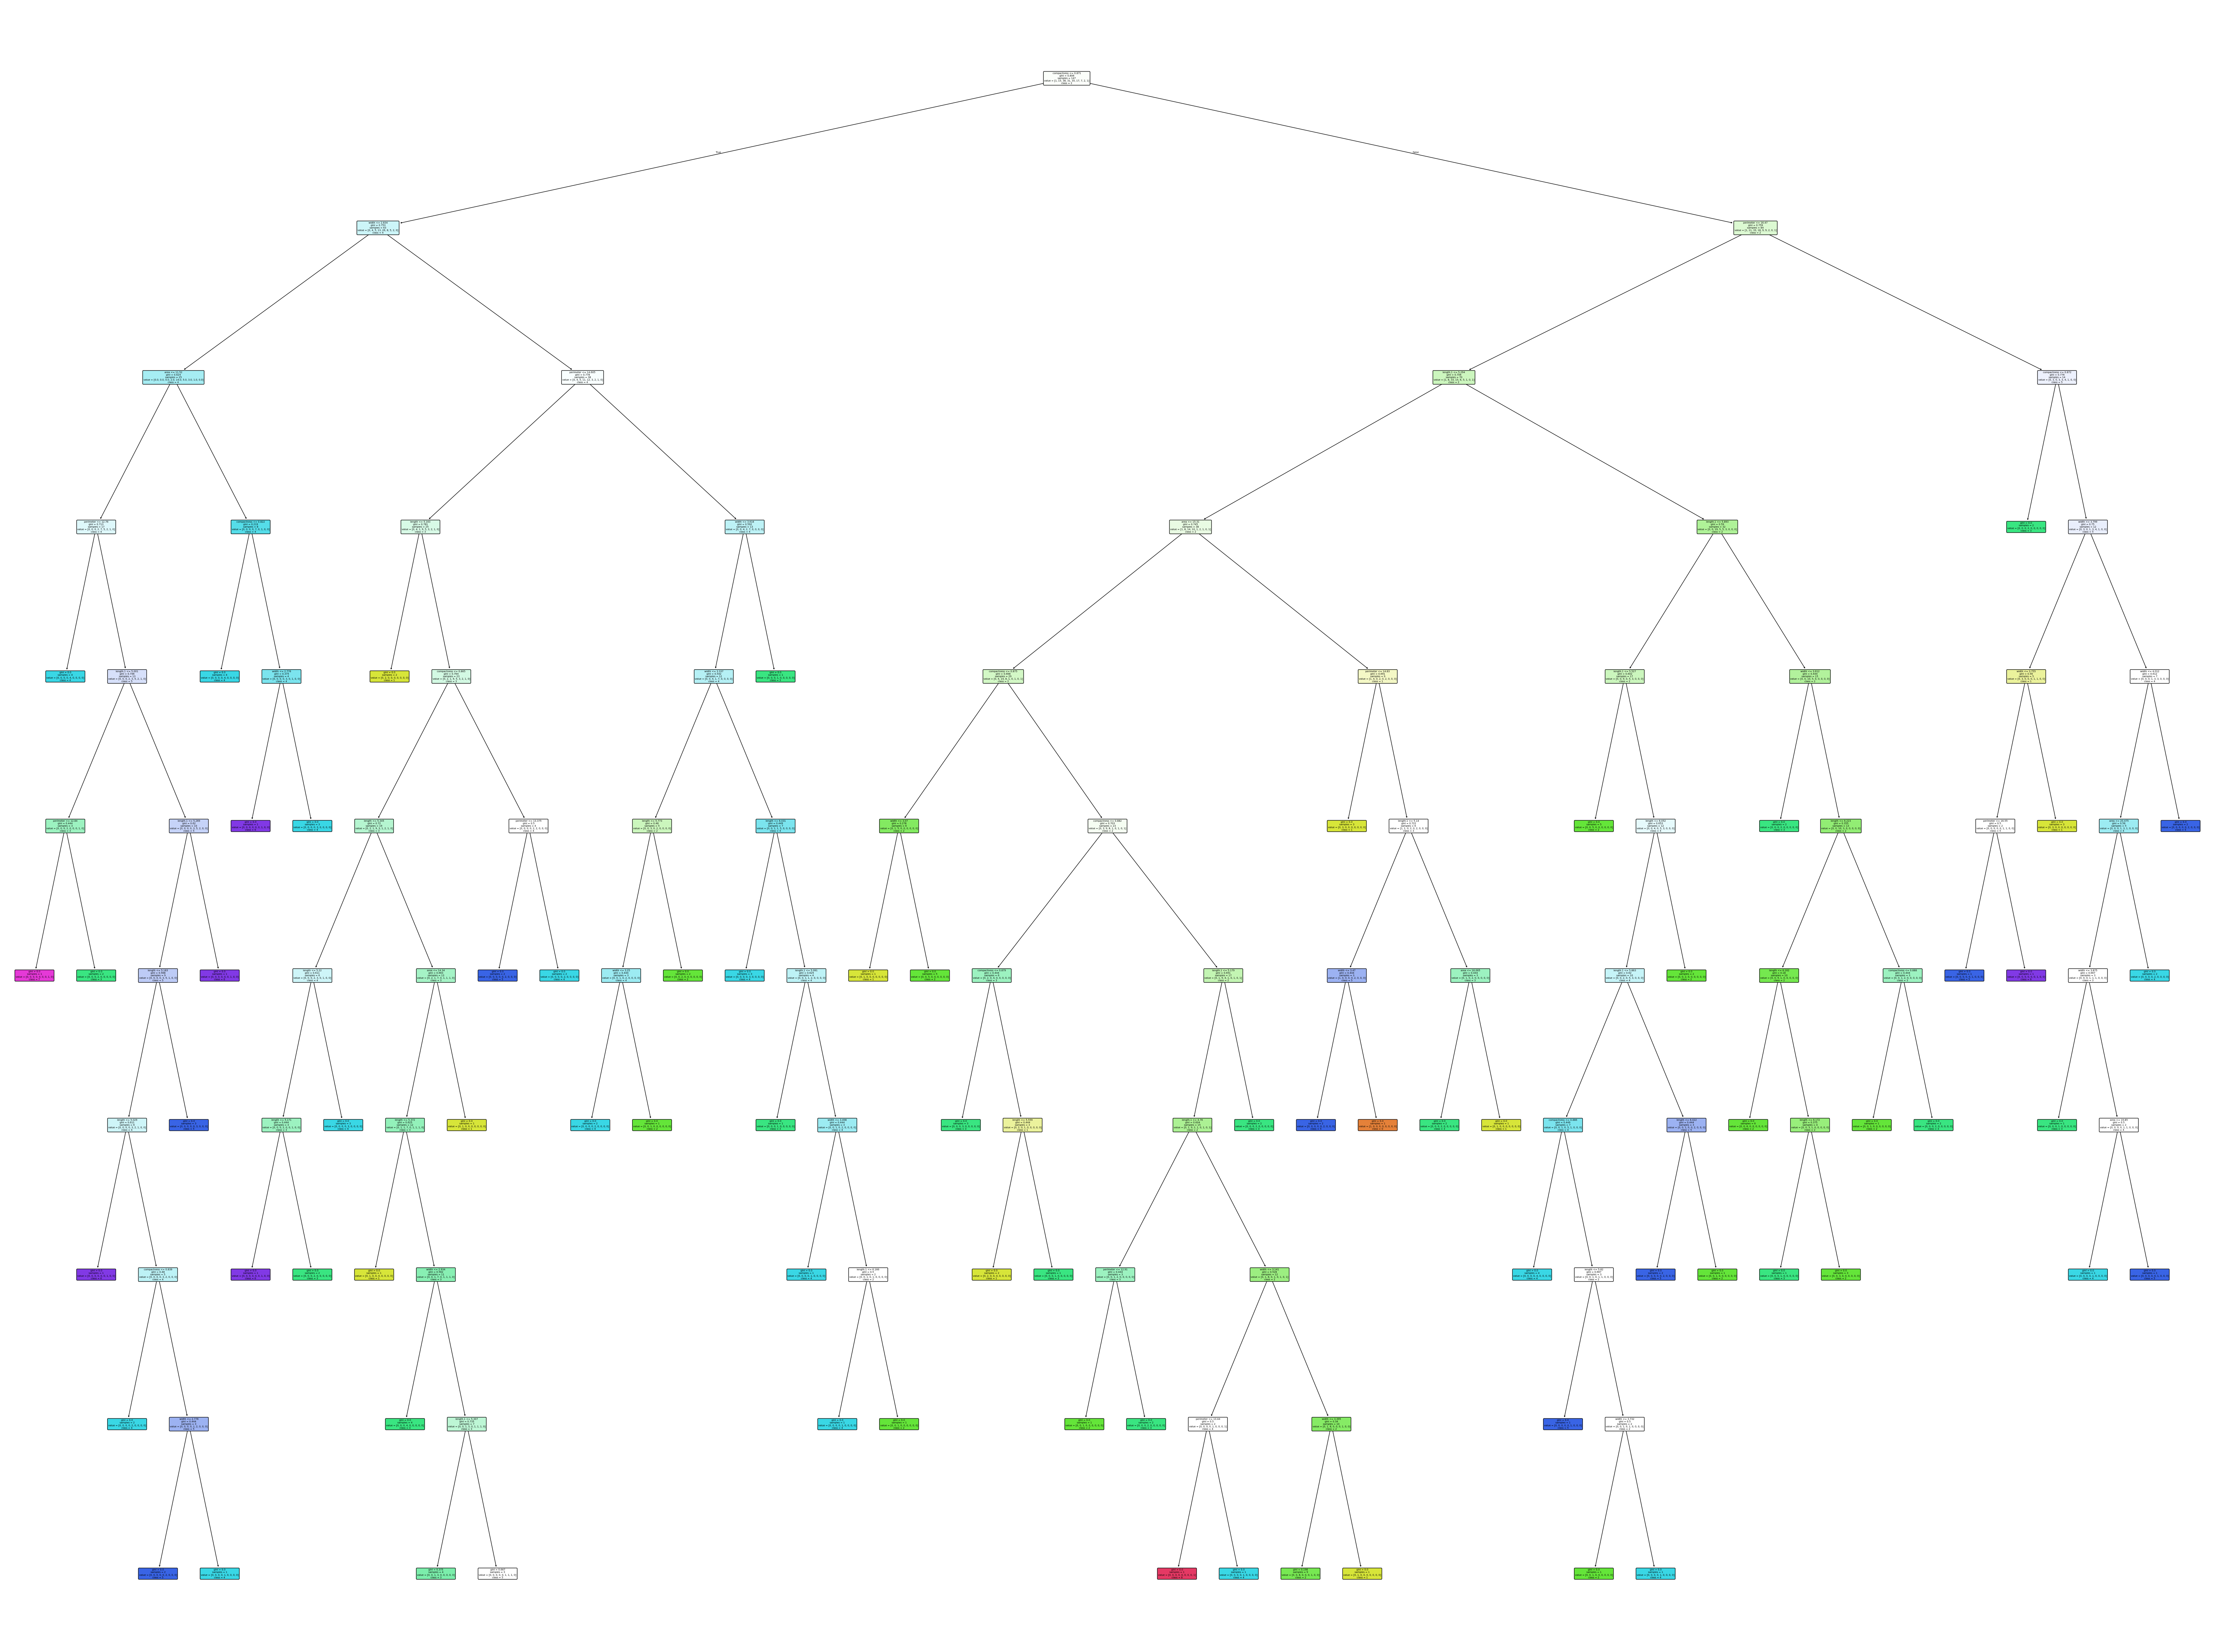

In [ ]:
from sklearn.tree import plot_tree
# Визуализируем дерево решений
plt.figure(figsize=(80, 60))
plot_tree(tree_model, feature_names=X.columns, class_names=[str(item) for item in sorted(y.unique())], filled=True, rounded=True)
plt.show()